# Title of our project: 

## Introduction: 

## Preliminary Data Analysis:

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 8) 

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
# read the brainstroke csv file into R by downloading/uploading it into Google Drive and using a direct output link
brainstroke_data <- read_csv("https://drive.google.com/uc?export=download&id=1yBiO_qBE9_YBvnEyPe2bazH5ZCOBb1d6")

brainstroke_data

Rows: 4981 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): gender, ever_married, work_type, Residence_type, smoking_status
dbl (6): age, hypertension, heart_disease, avg_glucose_level, bmi, stroke

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Male,40,0,0,Yes,Private,Urban,191.15,31.1,smokes,0
Female,45,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0
Male,40,0,0,Yes,Private,Rural,83.94,30.0,smokes,0
Female,80,1,0,Yes,Private,Urban,83.75,29.1,never smoked,0


In [4]:
##cleaning and wrangling data into a tidy format

# changing chr data to categorical data (gender, smoking status, work type, residence type, hypertension, heart disease)
# removing ever_married column
# changed Residence_type and bmi column names
brainstroke_data_v1 <- brainstroke_data |> 
    mutate(across(c(gender, hypertension:Residence_type, smoking_status:stroke),
                  as_factor)) |>
    select(1:4, 6:11)

colnames(brainstroke_data_v1)[6] <- 'residence_type'
colnames(brainstroke_data_v1)[8] <- 'body_mass_index'


# splitting into training/testing data set (75%:25% proportions)
brainstroke_split <- initial_split(brainstroke_data_v1, prop = 0.75, strata = stroke)

brainstroke_training <- training(brainstroke_split)
brainstroke_testing <- testing(brainstroke_split)

brainstroke_training

gender,age,hypertension,heart_disease,work_type,residence_type,avg_glucose_level,body_mass_index,smoking_status,stroke
<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>
Male,67,0,1,Private,Urban,228.69,36.6,formerly smoked,1
Male,80,0,1,Private,Rural,105.92,32.5,never smoked,1
Female,49,0,0,Private,Urban,171.23,34.4,smokes,1
Female,79,1,0,Self-employed,Rural,174.12,24.0,never smoked,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Male,58,0,0,Govt_job,Urban,84.94,30.2,never smoked,0
Male,41,0,0,Private,Rural,70.15,29.8,formerly smoked,0
Female,45,1,0,Govt_job,Rural,95.02,31.8,smokes,0
Male,40,0,0,Private,Rural,83.94,30.0,smokes,0


In [5]:
#FOR FACTOR DATA -  yes (1), no (0) (Variables: hypertension, heart disease, stroke)

In [6]:
##### summaries on training data
# creating objects for number of observations and number of those with/without stroke
total_obs <- nrow(brainstroke_training)
no_stroke_obs <- nrow(filter(brainstroke_training, stroke == 0))
stroke_obs <- nrow(filter(brainstroke_training, stroke == 1))


#####
# Summarized table 1: checking for missing data
not_available <- brainstroke_data_v1 |>
    summarize(across(everything(), ~ sum(is.na(.))))
not_available

# Summarized table 2: stroke counts and proportions
stroke_proportions <- brainstroke_training |>
    group_by(stroke) |>
    summarize(stroke_count = n(),
              percentage = round((stroke_count / total_obs) * 100, 2))
stroke_proportions

# Summarized table 3: average bmi, glucose level, and age of those with/without stroke
stroke_bmi_gluc_age_avg <- brainstroke_training |>
    group_by(stroke) |>
    summarise(avg_bmi = round(mean(body_mass_index), 2),
              avg_glucose = round(mean(avg_glucose_level), 2),
              avg_age = round(mean(age), 2))
stroke_bmi_gluc_age_avg

# Summarized table 4: smoking status counts and proportions between those who have/have not gotten a stroke
smoker_proportions_stroke <- brainstroke_training |>
    group_by(stroke, smoking_status) |>
    summarize(stroke_smoker_count = n(),
              percentage = round((stroke_smoker_count / 
              ifelse(stroke == 0, no_stroke_obs, stroke_obs) * 100), 2)) |>
    distinct()
smoker_proportions_stroke

# Summarized table 5: hypertension counts and proportions between those who have/have not gotten a stroke
hypertension_stroke <- brainstroke_training |>
    mutate(hypertension = ifelse(hypertension == 0, 'No', 'Yes')) |>
    group_by(stroke, hypertension) |>
    summarize(stroke_hypertension_count = n(),
              percentage = round((stroke_hypertension_count / 
              ifelse(stroke == 0, no_stroke_obs, stroke_obs) * 100), 2)) |>
    distinct()
hypertension_stroke

# Summarized table 6: heart disease counts and proportions between those who have/have not gotten a stroke
heart_disease_stroke <- brainstroke_training |>
    mutate(heart_disease = ifelse(heart_disease == 0, 'No', 'Yes')) |>
    group_by(stroke, heart_disease) |>
    summarize(stroke_heartdisease_count = n(),
              percentage = round((stroke_heartdisease_count / 
              ifelse(stroke == 0, no_stroke_obs, stroke_obs) * 100), 2)) |>
    distinct()   
heart_disease_stroke


gender,age,hypertension,heart_disease,work_type,residence_type,avg_glucose_level,body_mass_index,smoking_status,stroke
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0


stroke,stroke_count,percentage
<fct>,<int>,<dbl>
0,3537,94.7
1,198,5.3


stroke,avg_bmi,avg_glucose,avg_age
<fct>,<dbl>,<dbl>,<dbl>
0,28.35,104.59,41.74
1,30.27,133.03,68.05


`summarise()` has grouped output by 'stroke', 'smoking_status'. You can
override using the `.groups` argument.


stroke,smoking_status,stroke_smoker_count,percentage
<fct>,<fct>,<int>,<dbl>
0,formerly smoked,596,16.85
0,never smoked,1322,37.38
0,smokes,533,15.07
0,Unknown,1086,30.70
1,formerly smoked,56,28.28
1,never smoked,70,35.35
1,smokes,35,17.68
1,Unknown,37,18.69


`summarise()` has grouped output by 'stroke', 'hypertension'. You can override
using the `.groups` argument.


stroke,hypertension,stroke_hypertension_count,percentage
<fct>,<chr>,<int>,<dbl>
0,No,3235,91.46
0,Yes,302,8.54
1,No,142,71.72
1,Yes,56,28.28


`summarise()` has grouped output by 'stroke', 'heart_disease'. You can override
using the `.groups` argument.


stroke,heart_disease,stroke_heartdisease_count,percentage
<fct>,<chr>,<int>,<dbl>
0,No,3370,95.28
0,Yes,167,4.72
1,No,161,81.31
1,Yes,37,18.69


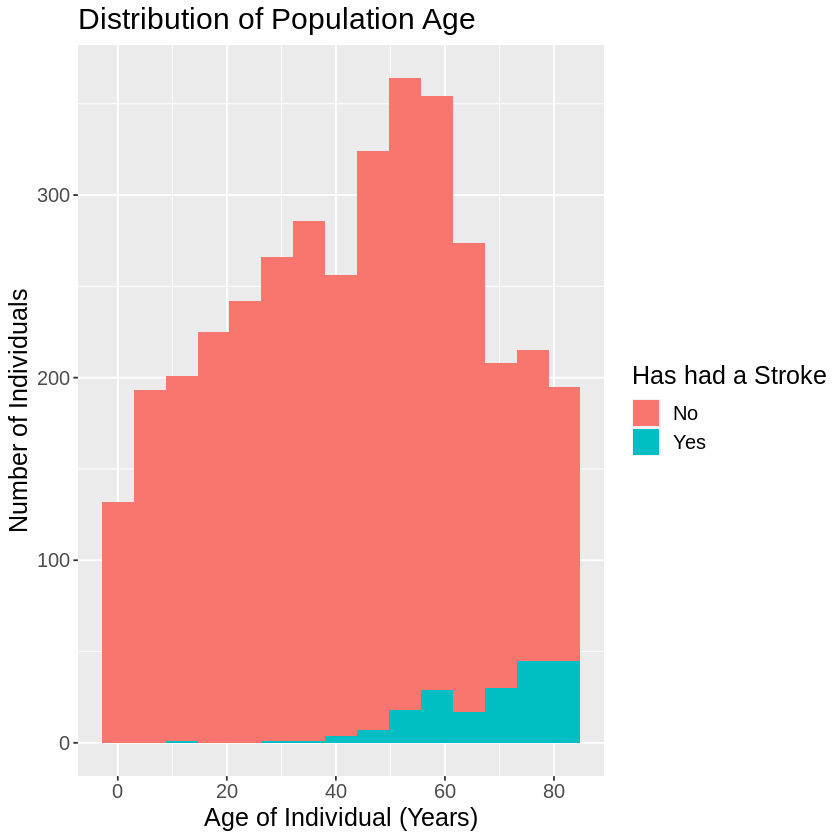

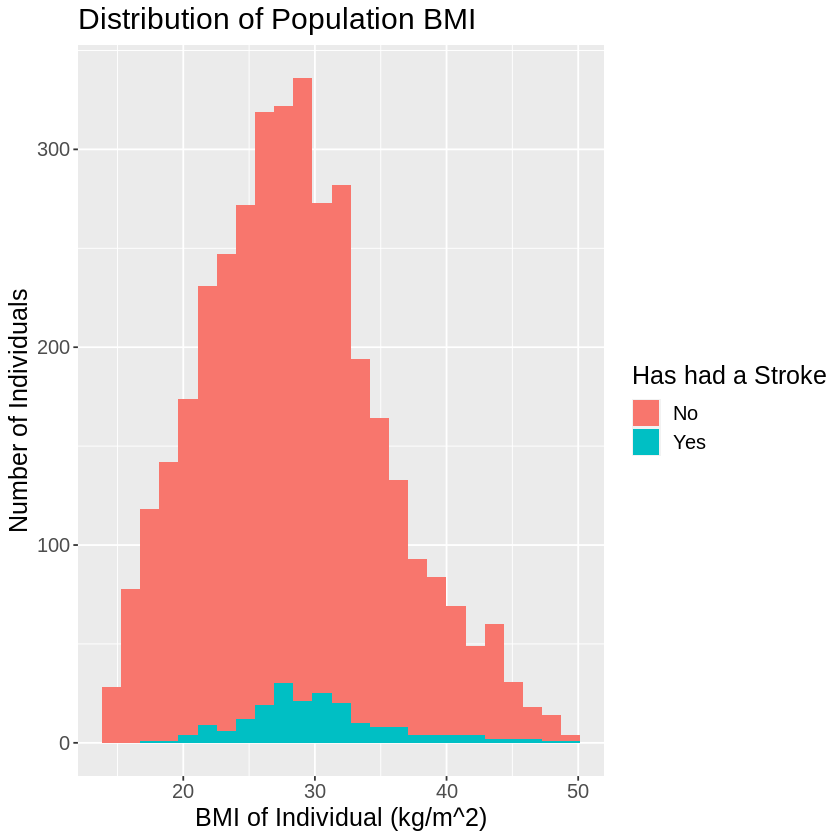

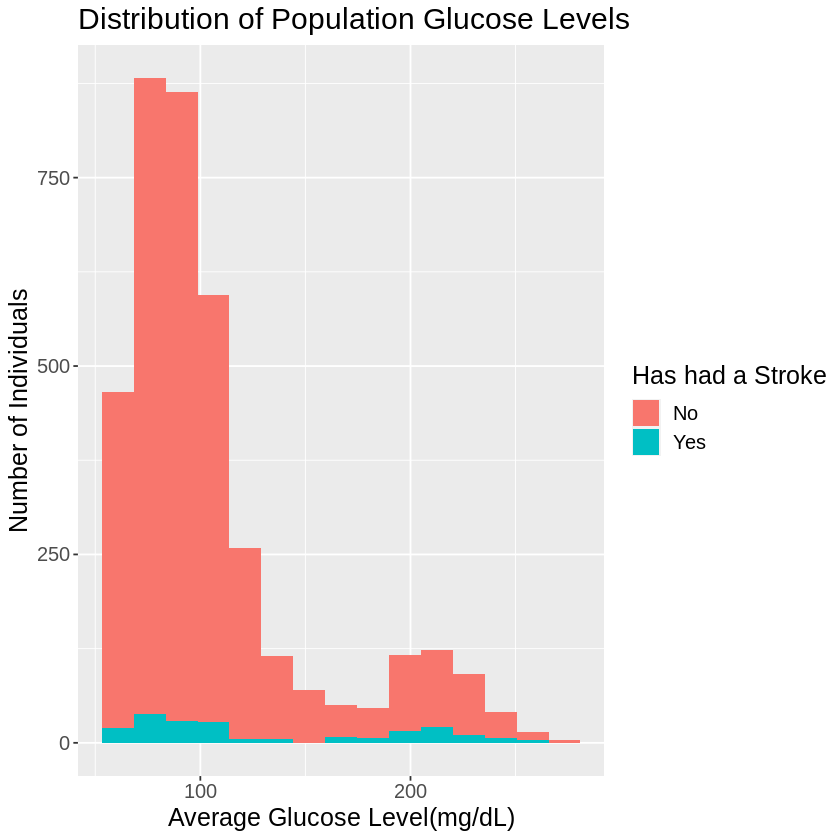

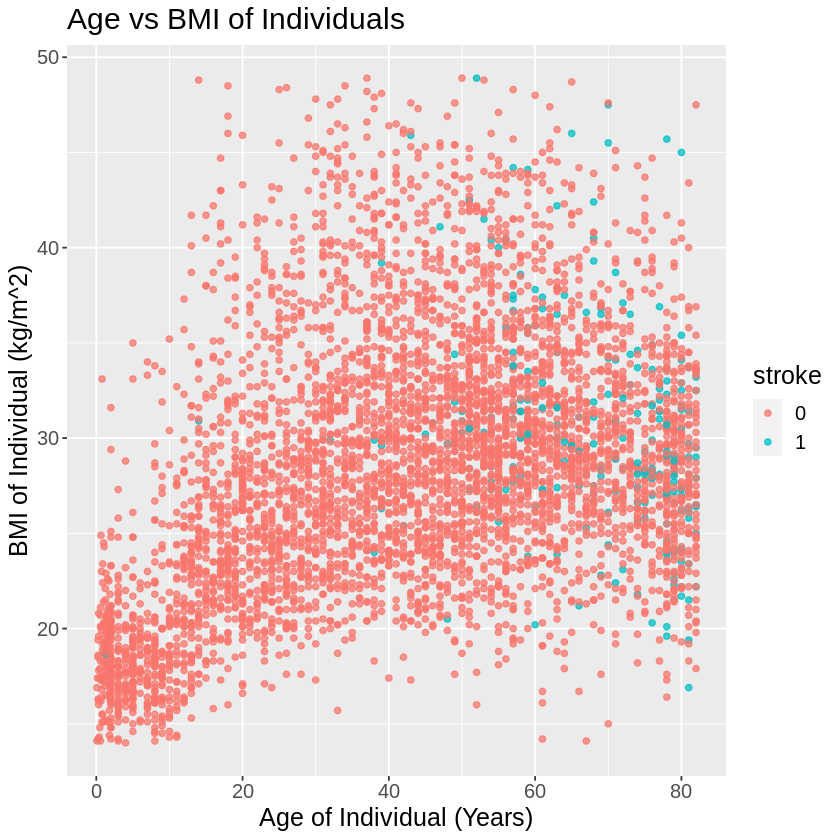

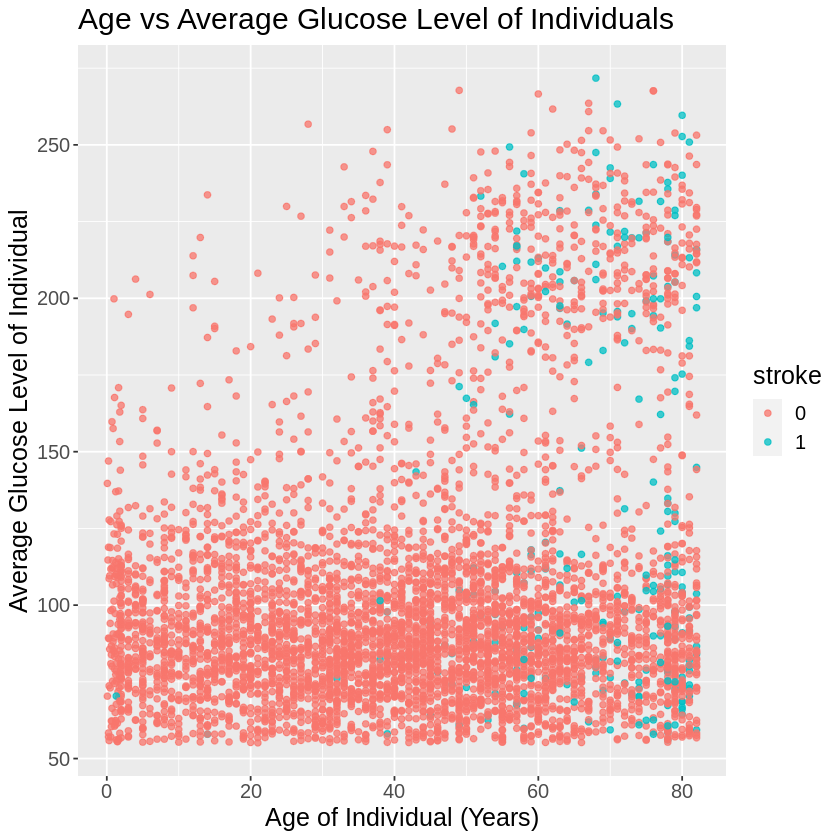

In [9]:
#####Visualizations

histogram_data <- brainstroke_training |>
    mutate(stroke = recode(stroke, '0' = "No", '1' = "Yes"))
    
#histogram 1: distribution of population age
age_histogram_plot <- histogram_data |>
    ggplot(aes(x = age, fill = stroke)) +
    geom_histogram(bins = 15) +
    xlab("Age of Individual (Years)") +
    ylab("Number of Individuals") +
    labs(fill = "Has had a Stroke") +
    ggtitle("Distribution of Population Age") +
    theme(text = element_text(size=15))

age_histogram_plot

#histogram 2: distribution of population BMI
bmi_histogram_plot <- histogram_data |>
    ggplot(aes(x = body_mass_index, fill = stroke)) +
    geom_histogram(bins = 25) +
    xlab("BMI of Individual (kg/m^2)") +
    ylab("Number of Individuals") +
    labs(fill = "Has had a Stroke") +
    ggtitle("Distribution of Population BMI") +
    theme(text = element_text(size=15))

bmi_histogram_plot

#histogram 3: distribution of population glucose levels
glucose_histogram_plot <- histogram_data |>
    ggplot(aes(x = avg_glucose_level, fill = stroke)) +
    geom_histogram(bins = 15) +
    xlab("Average Glucose Level(mg/dL)") +
    ylab("Number of Individuals") +
    labs(fill = "Has had a Stroke") +
    ggtitle("Distribution of Population Glucose Levels") +
    theme(text = element_text(size=15))

glucose_histogram_plot

#scatter plot 4: age VS BMI of individuals 
age_bmi_scatterplot <- brainstroke_data_v1 |>
    ggplot(aes(x = age, y = body_mass_index, color = stroke)) +
    geom_point(alpha = 0.75) +
    xlab("Age of Individual (Years)") +
    ylab("BMI of Individual (kg/m^2)") +
    ggtitle("Age vs BMI of Individuals") +
    theme(text = element_text(size=15))

age_bmi_scatterplot

#scatter plot 5: age VS glucose level of individuals 
age_glucose_scatterplot <- brainstroke_data_v1 |>
    ggplot(aes(x = age, y = avg_glucose_level, color = stroke)) +
    geom_point(alpha = 0.75) +
    xlab("Age of Individual (Years)") +
    ylab("Average Glucose Level of Individual") +
    ggtitle("Age vs Average Glucose Level of Individuals") +
    theme(text = element_text(size=15))

age_glucose_scatterplot

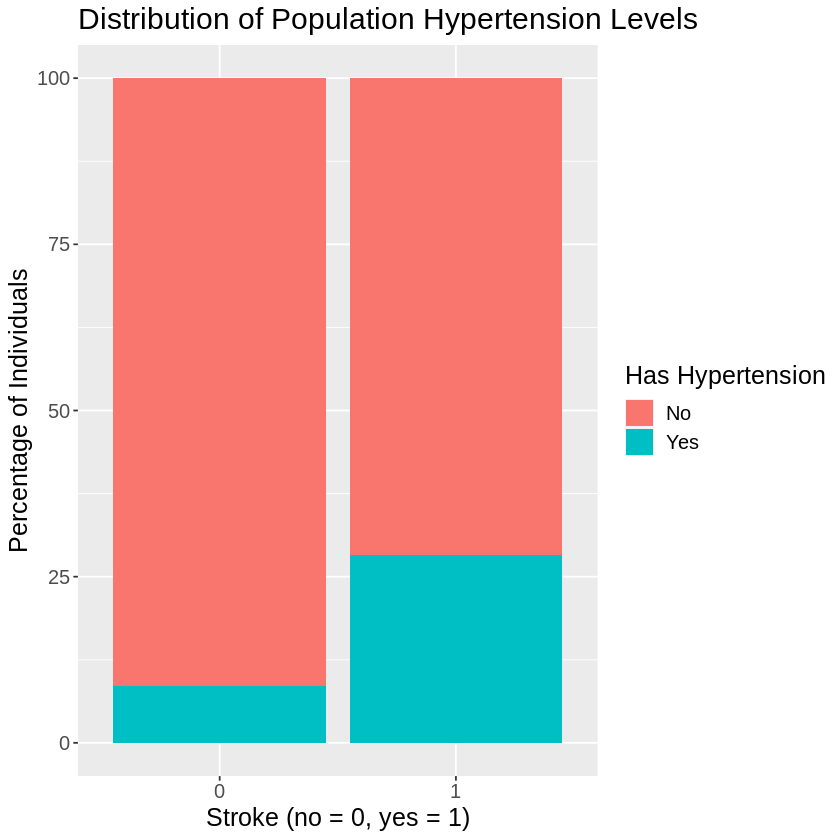

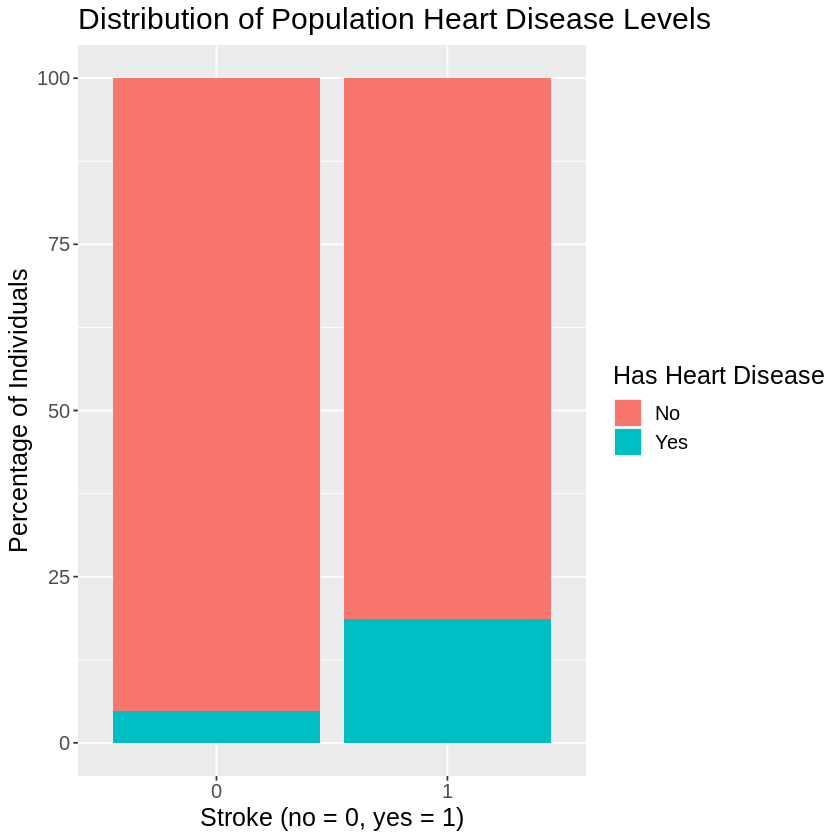

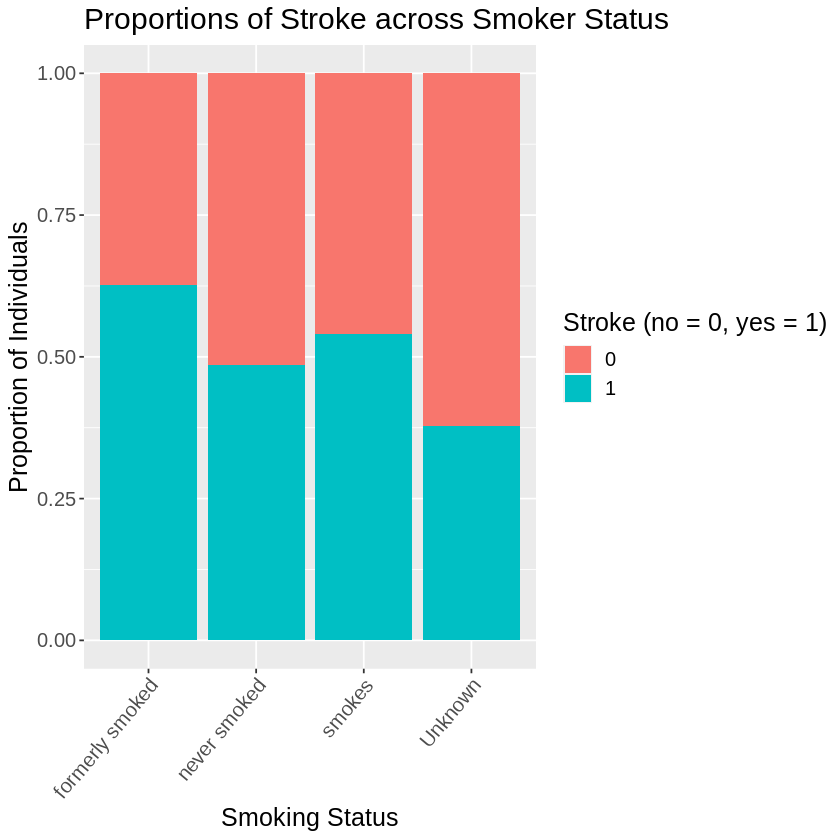

In [10]:
#distribution of population hypertension levels

hypertension_bar_plot <- hypertension_stroke |>
    ggplot(aes(x = stroke, y= percentage, fill = hypertension)) +
    geom_bar(stat = "identity") +
    xlab("Stroke (no = 0, yes = 1)") +
    ylab("Percentage of Individuals") +
    labs(fill = "Has Hypertension") +
    ggtitle("Distribution of Population Hypertension Levels") +
    theme(text = element_text(size=15))

hypertension_bar_plot 

#distribution of population heart disease levels
heartdisease_bar_plot <- heart_disease_stroke |>
    ggplot(aes(x = stroke, y= percentage, fill = heart_disease)) +
    geom_bar(stat = "identity") +
    xlab("Stroke (no = 0, yes = 1)") +
    ylab("Percentage of Individuals") +
    labs(fill = "Has Heart Disease") +
    ggtitle("Distribution of Population Heart Disease Levels") +
    theme(text = element_text(size=15))

heartdisease_bar_plot 

#distribution of population smoker status 
smoking_bar_plot <- smoker_proportions_stroke |>
    ggplot(aes(x = smoking_status, y= percentage, fill = stroke)) +
    geom_bar(stat = "identity", position = "fill") +
    xlab("Smoking Status") +
    ylab("Proportion of Individuals") +
    labs(fill = "Stroke (no = 0, yes = 1)") +
    ggtitle("Proportions of Stroke across Smoker Status") +
    theme(text = element_text(size=15)) + 
    theme(axis.text.x = element_text(angle = 50, hjust = 1))

smoking_bar_plot

## Methods

## Expected Outcomes and Significance

## References